In [1]:
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np
from scipy import io
from scipy.sparse import csr_matrix
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from scipy.cluster import hierarchy

import scipy as sp
from scipy.sparse.csgraph import minimum_spanning_tree
import networkx as nx

from collections import defaultdict
import matplotlib.cm as cm
from itertools import chain

from sklearn.externals import joblib

In [2]:
plt.rcParams['figure.figsize'] = (15, 10)

# Algorithm for pseudo time building

## Data preparation

In [3]:
mtx = io.mmread('GRCh38/matrix.mtx').transpose().todense()

In [4]:
mtx = mtx / np.sum(mtx, axis=1)

mtx = mtx.transpose()

In [5]:
std = np.array(np.ndarray.std(mtx, axis=1))[0]

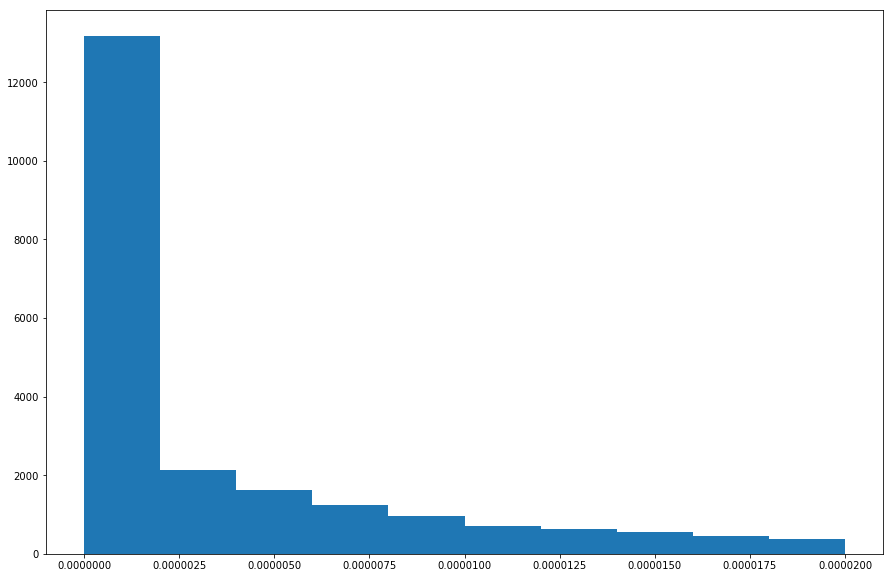

In [6]:
i = plt.hist(std,range=(0, 0.00002))

In [7]:
min_variance = 0.000050

mtx = np.delete(mtx, np.where(std < min_variance)[0], axis=0)

mtx = mtx.transpose()

In [8]:
mtx.shape

(8391, 7340)

In [9]:
princ_comp = PCA(100).fit_transform(mtx)

## Clustering

In [10]:
hier = hierarchy.linkage(princ_comp, method='ward')

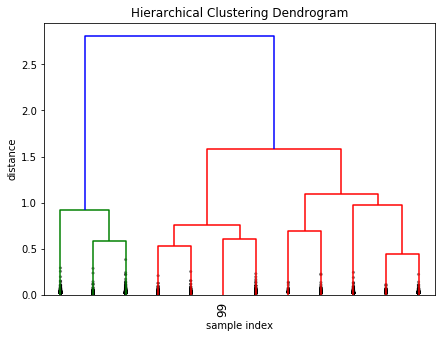

In [11]:
plt.figure(figsize=(7, 5))
plt.title('Hierarchical Clustering Dendrogram')
plt.xlabel('sample index')
plt.ylabel('distance')
hierarchy.dendrogram(
    hier,
    truncate_mode='lastp',  # show only the last p merged clusters
    p=12,  # show only the last p merged clusters
    show_leaf_counts=False,  # otherwise numbers in brackets are counts
    leaf_rotation=90.,
    leaf_font_size=12.,
    show_contracted=True,  # to get a distribution impression in truncated branches
);

In [12]:
classes = hierarchy.fcluster(hier, 0.4, criterion='distance')

In [154]:
classes = classes - 1

In [13]:
def get_class_centers(points, classes):
    return np.array([np.median(points[classes == cl], axis=0) for cl in np.unique(classes)])

In [14]:
centers = get_class_centers(princ_comp, classes)

## Graph construction

In [15]:
def get_dist_matrix(points):
        n = points.shape[0]
        
        dist_matrix = np.zeros([n, n])
        for i in range(n):
            for j in range(n):
                dist_matrix[i][j] = np.linalg.norm(points[i] - points[j])
        return dist_matrix

In [16]:
def get_links(nodes):
    links = []
    for ind, row in enumerate(nodes):
        links.extend([{'source':ind, 'target':x, 'value':row.item(x)} for x in np.where(row != 0)[1]])
    return links

In [17]:
dist_matr = get_dist_matrix(centers)

In [19]:
tree = minimum_spanning_tree(dist_matr).todense()

In [ ]:
links = get_links(tree)

## Data vizualization

### 3D

In [ ]:
projections = TSNE(3).fit_transform(princ_comp)

In [ ]:
import plotly.plotly as py
from plotly.graph_objs import *
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot

init_notebook_mode(connected=True)

def display_dots(dots, classes):
    # Dots
    Xn, Yn, Zn = dots[:,0], dots[:,1], dots[:,2] 
    
    trace = Scatter3d(x=Xn,
               y=Yn,
               z=Zn,
               mode='markers',
               name='actors',
               marker=Marker(symbol='dot',
                         size=2,
                         colorscale='Viridis',
                         line=Line(color='rgb(50,50,50)', width=0.5),
                         color=classes
                    )
               )
    
    return trace

def display_graph(dots, links):
    
    # Lines
    Xe, Ye, Ze = [], [], []

    for el in links:

        first = dots[el['source']]
        second = dots[el['target']]

        Xe += [first[0], second[0], None]
        Ye += [first[1], second[1], None]
        Ze += [first[2], second[2], None]
    
    # Dots
    Xn, Yn, Zn = dots[:,0], dots[:,1], dots[:,2] 
    
    labels = list(map(str, range(len(dots))))
    
    trace1 = Scatter3d( x=Xe,
                y=Ye,
                z=Ze,
                mode='lines',
                line=Line(color='rgb(125,125,125)', width=4),
                hoverinfo='none')
    
    trace2 = Scatter3d(x=Xn,
               y=Yn,
               z=Zn,
               mode='markers',
               name='actors',
               marker=Marker(symbol='dot',
                         size=5,
                         colorscale='rgb(255,0,0)',
                         line=Line(color='rgb(50,50,50)', width=0.5) ),
               text=labels,
               hoverinfo=['text', 'coordinates']
               )
    
    
    
    return trace1, trace2

def make_fig(traces, title="Default"):
    axis=dict(showbackground=False,
          showline=False,
          zeroline=False,
          showgrid=False,
          showticklabels=False,
          title=''
          )
    
    layout = Layout(
         title=title,
         width=1000,
         height=1000,
         showlegend=False,
         scene=Scene(
         xaxis=XAxis(axis),
         yaxis=YAxis(axis),
         zaxis=ZAxis(axis),
        ),
     margin=Margin(
        t=100)
    )
    
    data = Data(traces)
    
    fig=Figure(data=data, layout=layout)
    
    return fig

In [ ]:
trace1 = display_dots(projections, classes)

In [ ]:
trace2,trace3 = display_graph(centers_projections, links)

In [ ]:
fig = make_fig([trace1, trace2, trace3], title='PseudoTimeGraph')

In [ ]:
iplot(fig,filename='PseudoTime')

### 2D

In [25]:
def hierarchy_pos(G, root, width=1., vert_gap = 0.2, vert_loc = 0, xcenter = 0.5, 
                  pos = None, parent = None):
    '''If there is a cycle that is reachable from root, then this will see infinite recursion.
       G: the graph
       root: the root node of current branch
       width: horizontal space allocated for this branch - avoids overlap with other branches
       vert_gap: gap between levels of hierarchy
       vert_loc: vertical location of root
       xcenter: horizontal location of root
       pos: a dict saying where all nodes go if they have been assigned
       parent: parent of this branch.'''
    if pos == None:
        pos = {root:(xcenter,vert_loc)}
    else:
        pos[root] = (xcenter, vert_loc)
    neighbors = G.neighbors(root)
    if parent != None:
        neighbors.remove(parent)
    if len(neighbors)!=0:
        dx = width/len(neighbors) 
        nextx = xcenter - width/2 - dx/2
        for neighbor in neighbors:
            nextx += dx
            pos = hierarchy_pos(G,neighbor, width = dx, vert_gap = vert_gap, 
                                vert_loc = vert_loc-vert_gap, xcenter=nextx, pos=pos, 
                                parent = root)
    return pos

In [26]:
graph = nx.from_numpy_matrix(tree)

/home/max/anaconda3/lib/python3.5/site-packages/networkx/drawing/nx_pylab.py:126: MatplotlibDeprecationWarning: pyplot.hold is deprecated.
    Future behavior will be consistent with the long-time default:
    plot commands add elements without first clearing the
    Axes and/or Figure.
  b = plt.ishold()
/home/max/anaconda3/lib/python3.5/site-packages/networkx/drawing/nx_pylab.py:138: MatplotlibDeprecationWarning: pyplot.hold is deprecated.
    Future behavior will be consistent with the long-time default:
    plot commands add elements without first clearing the
    Axes and/or Figure.
  plt.hold(b)
/home/max/anaconda3/lib/python3.5/site-packages/matplotlib/__init__.py:917: UserWarning: axes.hold is deprecated. Please remove it from your matplotlibrc and/or style files.
  warnings.warn(self.msg_depr_set % key)
/home/max/anaconda3/lib/python3.5/site-packages/matplotlib/rcsetup.py:152: UserWarning: axes.hold is deprecated, will be removed in 3.0
  warnings.warn("axes.hold is deprecated

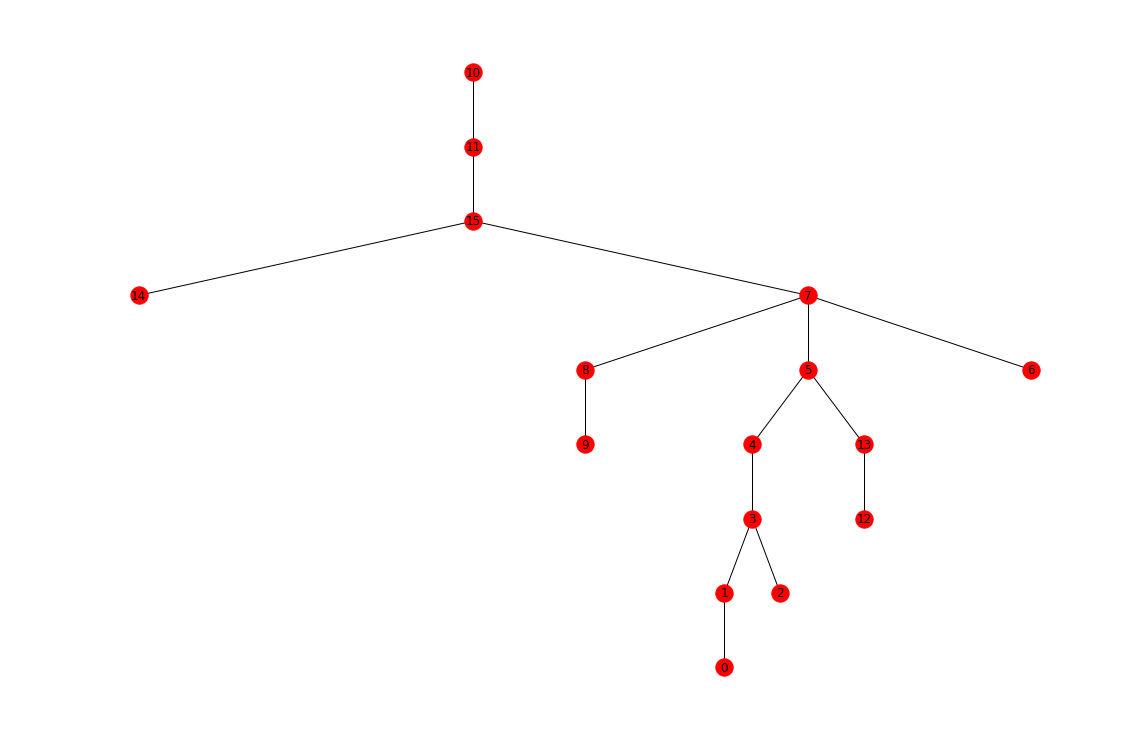

In [27]:
nx.draw(graph, pos=hierarchy_pos(graph, 10), with_labels=True, )

## Tree filtering

In [20]:
def get_adj_list(graph):
    adj_list = defaultdict(set)
    for ind, dem in enumerate(graph):
        possibilities = np.where(dem != 0)[1]

        adj_list[ind] = adj_list[ind].union(set(possibilities.tolist()))

        for poss in possibilities:
            adj_list[poss].add(ind)
    return adj_list

In [21]:
def get_longest_path(graph, start=None):
    '''
    If start is None, algorithm chooses start of the longest path in a graph.
    '''
    
    # It is possible to prove, that the the end of
    # the longest path from a random point is the start of the longest
    # path in a graph.
    
    if start is None:
        random_start = np.random.choice(list(graph.keys()))
        start = get_longest_path(graph, random_start)[-1]        
    
    stack = [(start, [start])]
    
    longest_path = [start]
    
    while stack:
        (vertex, path) = stack.pop()
        
        possible = graph[vertex] - set(path)
        
        if len(possible) == 0:
            if len(longest_path) < len(path):
                longest_path = list(path)
            
        for next in possible:
            stack.append((next, path + [next]))
            
    return longest_path

In [22]:
def get_branch_stats(adj_list, curr_node, next_node, dist_matr, begin_node):
    possible_ways = adj_list[next_node] - set([curr_node])
    
    if len(possible_ways) == 0:
        return (1, dist_matr[curr_node, next_node])
    
    stats = list(map(lambda x: get_branch_stats(adj_list, next_node, x, dist_matr, begin_node), possible_ways))
    
    sums = 1 + sum([x[0] for x in stats])
    dist = dist_matr[begin_node, next_node] + sum([x[1] for x in stats])
    
    return sums, dist

In [23]:
def get_branch(adj_list, node, next_node):
    if len(adj_list[next_node] - set([node])) == 0:
        return [node, next_node]
    next_step = (adj_list[next_node] - set([node])).pop()
    return list(chain(*[[node], get_branch(adj_list, next_node, next_step)]))

In [70]:
def get_tree_stats(adj_list, path, dist_matr):
    stats = []; inds = []; cluster_sizes = []

    for ind, node in enumerate(path):
        if len(adj_list[node]) > 2:
            possible_ways = list(adj_list[node] - set(path))

            addings = list(map(lambda x: get_branch_stats(adj_list, node, x, dist_matr, node), possible_ways))

            stats.extend(addings)
            inds.extend([(node, possible_ways[i]) for i in range(len(addings))])
            
    return list(zip([np.prod(x) for x in stats], inds))

### Merging

In [157]:
def merge(adj_list, from_node, to_node, classes):
    
    if len(adj_list[to_node]) != 1:
        possibilities = adj_list[to_node] - set([from_node])
        for poss in possibilities:
            adj_list, classes = merge(adj_list, to_node, poss, classes)       
    
    adj_list[from_node].remove(to_node)
    adj_list.pop(to_node)
    
    return adj_list, [from_node if x == to_node else x for x in classes]

In [192]:
def clean_tree(adj_list, path, dist_matr, classes, alpha=0.2):
    
    stats = get_tree_stats(adj_list, path, dist_matr)
    
    def construct_new_adj(vert, next_vert):
            new = adj_list.copy()
            new[vert] = set([next_vert])
            return new
    
    full_vertexes = list(filter(lambda x: x[0] > alpha, stats))
    small_vertexes = list(filter(lambda x: x[0] < alpha, stats))

    if len(full_vertexes):
        inds = [x[1] for x in full_vertexes]
        
        big_branches = list(map(lambda x: construct_new_adj(x[0], x[1]), inds))

        paths = list(map(lambda x: get_longest_path(x[0], x[1]), zip(big_branches, [x[0] for x in inds])))
        
        clean = list(map(lambda x: clean_tree(x[0], x[1], dist_matr, classes)[0], zip(big_branches, paths)))
                
        # Separate vertexes from the main tree.
        for ind in inds:
            adj_list[ind[0]].remove(ind[1])

    if len(small_vertexes):
        inds = [x[1] for x in small_vertexes]

        for ind in inds:
            adj_list, classes = merge(adj_list, ind[0], ind[1], classes)
                
    if len(full_vertexes):
        for (_, vrt), clean_branch in zip(full_vertexes, clean):
            next_node = list(clean_branch[vrt[0]])[0]
            vertexes = get_branch(clean_branch, vrt[0], next_node)

            adj_list[vertexes[0]] = adj_list[vertexes[0]].union(clean_branch[vertexes[0]])
            
            for v in vertexes[1:]:
                adj_list[v] = clean_branch[v]
            
    
    return adj_list, classes

### PQ Trees

In [ ]:
def get_indiciciev_backbone(adj_list, path):
    
    is_decisive = lambda x: len(adj_list[x]) <= 2

    longest = []

    for ind, vert in enumerate(path):
        if not is_decisive(vert):
            longest.append(ind)
            break
            
    for ind, vert in enumerate(reversed(path)):
        if not is_decisive(vert):
            longest.append(len(long)-ind)
            break
    
    return path[longest[0]:longest[1]] 

In [ ]:
def construct_pq(adj_list, path):
    
    is_decisive = lambda x: len(adj_list[x]) <= 2
    
    def construct_new_adj(vert):
        new = dict(adj_list)
        new[vert] = adj_list[vert] - set(path)
        return new
    
    q_node = {'q': list()}
    
    for vert in path:
        if is_decisive(vert):
            q_node['q'].append(vert)
            
        else:
            possible_nodes = list(adj_list[vert] - set(path))
            
            vertexes = list(map(construct_new_adj, possible_nodes))
            
            paths = [get_longest_path(vertexes[i], possible_nodes[i]) for i in range(len(possible_nodes))]

            p_node_raw = [construct_pq(vertexes[i], paths[i]) for i in range(len(possible_nodes))]
            p_node_raw.append({'q':[vert]})

            p_node = {}; p_node['p'] = p_node_raw
            
            q_node['q'].append(p_node)
    
    return q_node

In [ ]:
def adj_from_array(array):
    adj_list = {}
    
    adj_list[array[0]] = set([array[1]])
    adj_list[array[-1]] = set([array[-2]])
    
    for i in range(1, len(array)-1):
        adj_list[array[i]] = set([array[i-1], array[i+1]])
        
    return adj_list

In [ ]:
class Anea_Optim:
    def __init__(self, temp_func, energy_func, next_state_func, start_temp=10, end_temp=0.001):
        self.temp_func = temp_func
        self.energy_func = energy_func
        self.next_state_func = next_state_func
        
        self.start_temp = start_temp
        self.end_temp = end_temp
        
    def optimize(self, starting_state):
        
        temp = self.start_temp
        state = starting_state
        i = 1
        
        while temp > self.end_temp:
            next_state = self.next_state_func(state)
            
            delta_energy = self.energy_func(next_state) - self.energy_func(state)
            
            if delta_energy <= 0:
                step_prob = 1
            else:
                step_prob = np.exp(-delta_energy/temp)
            
            universe_dice = np.random.rand()
            
            if universe_dice < step_prob:
                state = next_state
            
            temp = self.temp_func(self.start_temp, i)
            i += 1
    
        return state

def temp(initial, i):
    return initial * 0.1 / i

def energy(state, dist_matr):
    en = 0
    for i in range(len(state)-1):
        en += dist_matr[state[i][-1], state[i+1][0]]
    return en

def next_state(state):
    copy = list(state)

    flip = np.random.choice([0, 1])
    ind = np.random.choice(list(range(len(state))))

    if flip:
        copy[ind] = list(reversed(copy[ind]))
    else:
        swap_ind = np.random.choice(list(range(len(state))))

        temp = copy[ind]
        copy[ind] = copy[swap_ind]
        copy[swap_ind] = temp
    
    return copy

In [ ]:
def reconstruct(node, dist_matr, optimizer, optim_iter=5):
    
    applied_recon = lambda x: reconstruct(x, dist_matr, optimizer)
    
    if type(node) == int:
        return [node]
    
    key = list(node.keys())[0]
    
    parsed = list(map(applied_recon, node[key]))
    if key == 'p':
        paths = []

        for i in range(optim_iter):
            guess = optimizer.optimize(parsed)
            paths.append(guess)

        optimal_path = min(paths, key=optimizer.energy_func)

        return list(chain(*optimal_path))
    else:
        return list(chain(*parsed))
            

In [ ]:
def clean_tree(adj_list, path, dist_matr, alpha=0.2):
    
    stats = get_tree_stats(adj_list, path, dist_matr)
    
    def construct_new_adj(vert):
            new = adj_list.copy()
            new[vert] = adj_list[vert] - set(path)
            return new
    
    full_vertexes = list(filter(lambda x: x[0] > alpha, stats))
    if len(full_vertexes):
        inds = [x[1] for x in full_vertexes]
    
        big_branches = list(map(construct_new_adj, inds))
        
        paths = list(map(lambda x: get_longest_path(x[0], x[1]), zip(big_branches, inds)))
        
        clean = list(map(lambda x: clean_tree(x[0], x[1], dist_matr), zip(big_branches, paths)))
        
        adj_list = adj_list.copy()
        
        # Separate vertexes from the main tree.
        for ind in inds:
            adj_list[ind] = adj_list[ind].intersection(set(path))
    
    indic = get_indiciciev_backbone(adj_list, path)
    
    pq_tree = construct_pq(adj_list, indic)
    
    our_energy = lambda x: energy(x, dist_matr)
    
    optimizer = Anea_Optim(temp, our_energy, next_state)
    
    cleaned_tree = adj_from_array(reconstruct(pq_tree, dist_matr, optimizer))

    if len(full_vertexes):
        for (_, vrt), clean_branch in zip(full_vertexes, clean):
            next_node = list(clean_branch[vrt])[0]
            vertexes = get_branch(clean_branch, vrt, next_node)
            cleaned_tree[vertexes[0]] = cleaned_tree[vertexes[0]].union(clean_branch[vertexes[0]])
            
            for v in vertexes[1:]:
                cleaned_tree[v] = clean_branch[v]
            
    
    return cleaned_tree

### Filtering

In [228]:
adj_list = get_adj_list(tree)

In [42]:
long = get_longest_path(adj_list)

In [229]:
cleaned_tree, new_classes = clean_tree(adj_list.copy(), long, dist_matr, classes, alpha=0.3)

In [161]:
def adj_list_to_matr(adj_list, dist_matr):
    matr_shape = dist_matr.shape
    
    matr = np.zeros(matr_shape)
    
    for k in adj_list.keys():
        for j in adj_list[k]:
            matr[k][j] = dist_matr[k, j]
    
    return matr

In [196]:
clean_graph = nx.from_numpy_matrix(adj_list_to_matr(cleaned_tree, dist_matr))

/home/max/anaconda3/lib/python3.5/site-packages/networkx/drawing/nx_pylab.py:126: MatplotlibDeprecationWarning: pyplot.hold is deprecated.
    Future behavior will be consistent with the long-time default:
    plot commands add elements without first clearing the
    Axes and/or Figure.
  b = plt.ishold()
/home/max/anaconda3/lib/python3.5/site-packages/networkx/drawing/nx_pylab.py:138: MatplotlibDeprecationWarning: pyplot.hold is deprecated.
    Future behavior will be consistent with the long-time default:
    plot commands add elements without first clearing the
    Axes and/or Figure.
  plt.hold(b)
/home/max/anaconda3/lib/python3.5/site-packages/matplotlib/__init__.py:917: UserWarning: axes.hold is deprecated. Please remove it from your matplotlibrc and/or style files.
  warnings.warn(self.msg_depr_set % key)
/home/max/anaconda3/lib/python3.5/site-packages/matplotlib/rcsetup.py:152: UserWarning: axes.hold is deprecated, will be removed in 3.0
  warnings.warn("axes.hold is deprecated

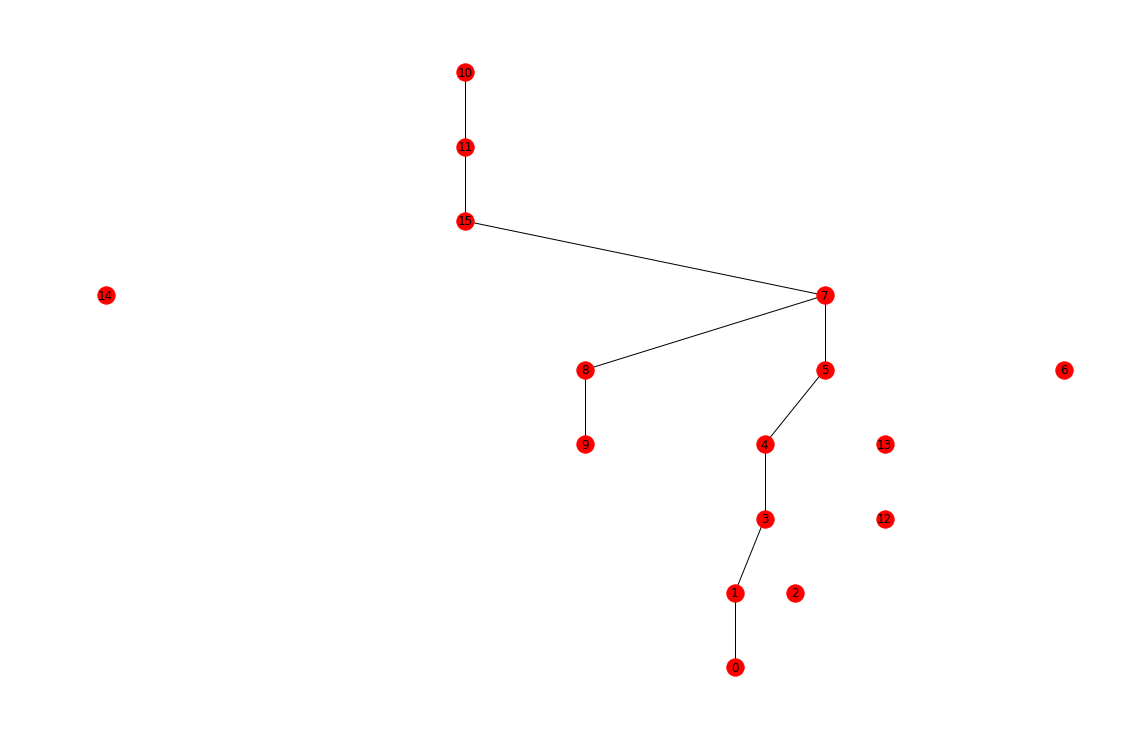

In [197]:
nx.draw(clean_graph, pos=hierarchy_pos(graph, 10), with_labels=True, )

In [203]:
np.array(new_classes).dump('classes.pcl')

In [244]:
joblib.dump(cleaned_tree, 'cleaned_tree.jl')

['cleaned_tree.jl']

In [19]:
def generate_pairs(adj_list, start_node=None, next_node=None):
    
    if start_node is None:
        start_node = list(filter(lambda x: len(x[1]) == 1, cleaned_tree.items()))[0][0] 
        next_node = list(adj_list[start_node])[0]
        
    pairs = [(start_node, next_node)]
    
    next_ways = adj_list[next_node] - set([start_node])
    
    return pairs + list(chain(*list(map(lambda x: generate_pairs(adj_list, next_node, x), next_ways))))

## Cell type determination

In [4]:
import pandas as pd
from scipy.stats.distributions import norm
from statsmodels.sandbox.stats.multicomp import multipletests

In [5]:
%time clean_mtx = np.array(io.mmread('GRCh38/matrix.mtx').transpose().todense())

CPU times: user 27.6 s, sys: 1.79 s, total: 29.4 s
Wall time: 35.2 s


In [6]:
cleaned_tree = joblib.load('cleaned_tree.jl')
classes = np.load('classes.pcl')

### Renaming current genes to GO format

In [6]:
genes = pd.read_table('GRCh38/genes.tsv', header=None)

In [7]:
ensemble_ids = np.array(genes[0])

In [8]:
ensemble_to_go = pd.read_csv('ensebml_to_go.csv', index_col='ensembl_gene_id')

In [9]:
filter_index = list(map(lambda x: x in ensemble_to_go.index, ensemble_ids))

In [10]:
gene_names = np.array(list(ensemble_to_go.loc[ensemble_ids[filter_index]].hgnc_symbol))

In [11]:
clean_mtx = clean_mtx[:, filter_index]

In [12]:
filter_index = clean_mtx.sum(axis=0) > 0

In [13]:
clean_mtx = clean_mtx[:, filter_index]
gene_names = gene_names[filter_index]

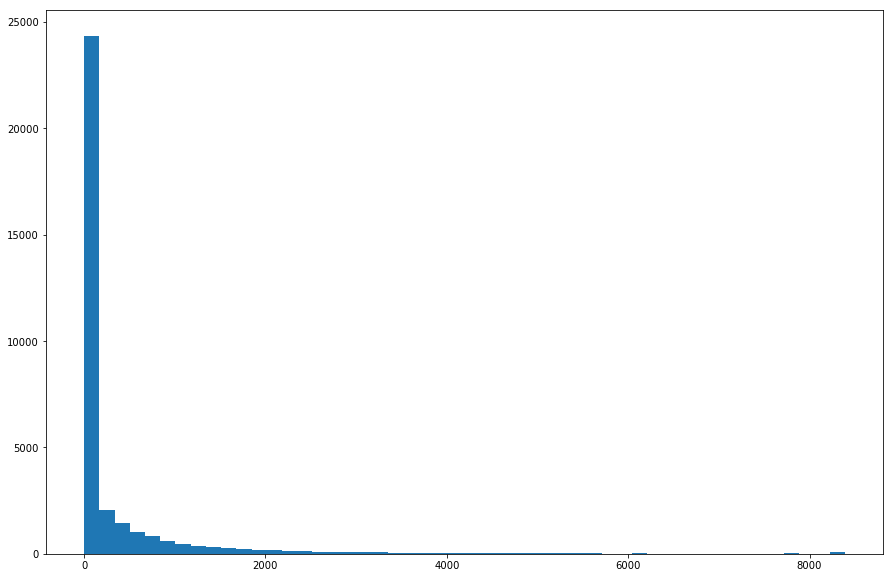

In [7]:
plt.hist((clean_mtx > 0).sum(axis=0), bins=50);

In [8]:
filter_index = (clean_mtx > 0).sum(axis=0) > 30

In [ ]:
clean_mtx = clean_mtx[:, filter_index]
gene_names = gene_names[filter_index]

Нормализуем

In [ ]:
clean_mtx = (clean_mtx.T / clean_mtx.sum(axis=1)).T

Перед анализом матрицу надо логарифмировать, чтобы распределение стало ближе к нормальному:

In [ ]:
clean_mtx_log = np.log(1e-6 + clean_mtx)

In [ ]:
clean_mtx_log.dump('clean_mtx_log.pcl')
gene_names.dump('gene_names.pcl')

In [14]:
clean_mtx_log = np.load('clean_mtx_log.pcl')
gene_names = np.load('gene_names.pcl')

In [15]:
def z_score(first_cluster, second_cluster):
    first_mean = first_cluster.mean(1)
    first_var = first_cluster.var(1)

    second_mean = second_cluster.mean(1)
    second_var = second_cluster.var(1)
    
    Z = (first_mean - second_mean) / np.sqrt(first_var/first_cluster.shape[0] + second_var/second_cluster.shape[0])
    
    return Z

In [16]:
def get_diff_names(first_cluster, second_cluster, names, alpha=1e-3):
    scores = z_score(first_cluster, second_cluster)
    
    pvals = 1 - sp.stats.norm.cdf(scores)
    pvals_adj = multipletests(pvals, method='holm')[1]
    
    return names[pvals_adj < alpha]

### Proccessing

In [20]:
pairs = generate_pairs(cleaned_tree)

In [21]:
pairs

[(0, 1),
 (1, 3),
 (3, 4),
 (4, 5),
 (5, 7),
 (7, 8),
 (8, 9),
 (7, 15),
 (15, 11),
 (11, 10)]

In [33]:
names = list(map(lambda x: get_diff_names(clean_mtx_log[classes == x[0]].T, clean_mtx_log[classes == x[1]].T, gene_names), pairs))

### Enrichment analysis

Download

In [ ]:
del results_proc

In [37]:
from goatools.base import download_go_basic_obo, download_ncbi_associations

In [186]:
obo_fname = download_go_basic_obo()
gene2go = download_ncbi_associations()


  DOWNLOADED: go-basic.obo

  DOWNLOADED: gene2go


Read

In [38]:
from goatools.obo_parser import GODag

obodag = GODag("go-basic.obo")

load obo file go-basic.obo
go-basic.obo: fmt(1.2) rel(2017-08-31) 46,942 GO Terms


In [39]:
from goatools.associations import read_ncbi_gene2go

gene2go = read_ncbi_gene2go("gene2go", taxids=[9606])

In [40]:
from genes_NCBI_9606_ProteinCoding import GeneID2nt

Begin study

In [41]:
from goatools.go_enrichment import GOEnrichmentStudy

goeaobj = GOEnrichmentStudy(
        GeneID2nt.keys(), # List of mouse protein-coding genes
        gene2go, # geneid/GO associations
        obodag, # Ontologies
        propagate_counts = False,
        alpha = 0.05, # default significance cut-off
        methods = ['fdr_bh']) # defult multipletest correction method

18,397 out of 20,913 population items found in association


In [42]:
gene2id = {GeneID2nt[x].Symbol : x for x in GeneID2nt.keys()}

In [43]:
def has_key(key, dict_):
    try:
        dict_[key]
        return True
    except:
        return False

In [44]:
study_results = []

In [46]:
for n in names:
    test = list(filter(lambda x: x!='_', [gene2id[x] if has_key(x, gene2id) else '_' for x in n]))
    results_raw = goeaobj.run_study(test)
    study_results.append(results_raw)

Calculating uncorrected p-values using fisher
 1,358 out of  1,399 study items found in association
Running multitest correction: statsmodels fdr_bh
  5,419 GO terms are associated with 1,358 of 1,399 study items
  17,438 GO terms are associated with 18,397 of 20,913 population items
Calculating uncorrected p-values using fisher
   382 out of    394 study items found in association
Running multitest correction: statsmodels fdr_bh
  2,928 GO terms are associated with 382 of 394 study items
  17,438 GO terms are associated with 18,397 of 20,913 population items
Calculating uncorrected p-values using fisher
 2,348 out of  2,393 study items found in association
Running multitest correction: statsmodels fdr_bh
  7,790 GO terms are associated with 2,348 of 2,393 study items
  17,438 GO terms are associated with 18,397 of 20,913 population items
Calculating uncorrected p-values using fisher
 5,105 out of  5,203 study items found in association
Running multitest correction: statsmodels fdr_bh


In [47]:
results_proc = list(map(lambda results_raw: [r for r in results_raw if r.p_fdr_bh < 0.05], study_results))

In [61]:
from goatools.godag_plot import plot_gos, plot_results, plot_goid2goobj

In [63]:
for i, res in enumerate(results_proc):
    plot_results("results/"+str(i)+"_{NS}.png", res)

    4 usr  43 GOs  WROTE: results/0_BP.png
    3 usr  12 GOs  WROTE: results/0_MF.png
    4 usr  15 GOs  WROTE: results/0_CC.png
   40 usr 321 GOs  WROTE: results/1_BP.png
    8 usr  36 GOs  WROTE: results/1_MF.png
   18 usr  58 GOs  WROTE: results/1_CC.png
   36 usr 287 GOs  WROTE: results/2_BP.png
   16 usr  52 GOs  WROTE: results/2_MF.png
   39 usr 121 GOs  WROTE: results/2_CC.png
  289 usr 1133 GOs  WROTE: results/3_BP.png
   99 usr 266 GOs  WROTE: results/3_MF.png
  129 usr 269 GOs  WROTE: results/3_CC.png
  236 usr 989 GOs  WROTE: results/4_BP.png
   80 usr 197 GOs  WROTE: results/4_MF.png
  115 usr 228 GOs  WROTE: results/4_CC.png
  141 usr 775 GOs  WROTE: results/5_BP.png
   47 usr 139 GOs  WROTE: results/5_MF.png
   74 usr 173 GOs  WROTE: results/5_CC.png
  295 usr 1116 GOs  WROTE: results/6_BP.png
  124 usr 300 GOs  WROTE: results/6_MF.png
  137 usr 267 GOs  WROTE: results/6_CC.png
  216 usr 979 GOs  WROTE: results/7_BP.png
   79 usr 227 GOs  WROTE: results/7_MF.png
  121 usr